# kNN Trading Strategy - Multi-Asset Framework

## Overview
Comprehensive backtesting framework using k-Nearest Neighbours machine learning for trading.

**Features:**
- Multi-Asset: Stocks, Crypto, Commodities, Forex
- Multi-Timeframe: 5m, 15m, 1h, 4h, 1d
- Technical Indicators: RSI, CCI, ROC, Volume (normalized)
- Full Backtesting & Comparison Tools

**Quick Start:**
```python
results = evaluate_knn_strategy('BTC-USD', interval='1h')
print_results(results)
plot_results(results)
```


In [1]:
# Installation (uncomment if needed)
# !pip install yfinance pandas numpy matplotlib seaborn scikit-learn

In [2]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('✓ Imports loaded')


✓ Imports loaded


## Core Functions


In [3]:
# ============================================================================
# TECHNICAL INDICATORS
# ============================================================================

def calculate_rsi(prices, period=14):
    """Relative Strength Index"""
    delta = prices.diff()
    gain = delta.where(delta > 0, 0).rolling(period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_cci(high, low, close, period=20):
    """Commodity Channel Index"""
    tp = (high + low + close) / 3
    sma = tp.rolling(period).mean()
    mad = tp.rolling(period).apply(lambda x: np.abs(x - x.mean()).mean())
    return (tp - sma) / (0.015 * mad)

def calculate_roc(prices, period=12):
    """Rate of Change"""
    return ((prices - prices.shift(period)) / prices.shift(period)) * 100

def minimax_normalize(series, period, min_val=0, max_val=100):
    """Normalize to [min_val, max_val] over rolling window"""
    result = pd.Series(index=series.index, dtype=float)
    for i in range(period-1, len(series)):
        window = series.iloc[i-period+1:i+1]
        hi, lo = window.max(), window.min()
        result.iloc[i] = (max_val - min_val) * (series.iloc[i] - lo) / (hi - lo) + min_val if hi != lo else min_val
    return result

def calculate_atr(high, low, close, period=14):
    """Average True Range"""
    tr = pd.concat([high - low, abs(high - close.shift()), abs(low - close.shift())], axis=1).max(axis=1)
    return tr.rolling(period).mean()

def normalize_features(df, feature_columns, method='minmax'):
    """Normalize features to [0, 1] range"""
    df_norm = df.copy()
    for col in feature_columns:
        if method == 'minmax':
            col_min, col_max = df[col].min(), df[col].max()
            df_norm[f'{col}_norm'] = (df[col] - col_min) / (col_max - col_min) if col_max != col_min else 0.5
    return df_norm

# ============================================================================
# kNN ALGORITHM (using sklearn)
# ============================================================================

def knn_predict(current_features, features_history, directions_history, k):
    """kNN prediction using sklearn NearestNeighbors
    
    Returns:
    --------
    prediction : float
        Sum of directions from k nearest neighbors
    confidence : float
        Confidence score between 0 and 1, based on:
        - Distance to neighbors (closer = higher confidence)
        - Agreement among neighbors (more unanimous = higher confidence)
    """
    if len(features_history) == 0:
        return 0, 0.0
    
    # Convert to numpy arrays
    try:
        X_history = np.array(features_history)
        X_current = np.array(current_features).reshape(1, -1)
        y_history = np.array(directions_history)
    except (ValueError, TypeError):
        return 0, 0.0
    
    # Check for NaN values
    if np.any(np.isnan(X_current)) or np.any(np.isnan(X_history)):
        return 0, 0.0
    
    # Ensure we have enough samples
    if len(X_history) < 1:
        return 0, 0.0
    
    # Use sklearn NearestNeighbors
    n_neighbors = min(k, len(X_history))
    nn = NearestNeighbors(n_neighbors=n_neighbors, metric='euclidean')
    nn.fit(X_history)
    
    # Find k nearest neighbors
    distances, indices = nn.kneighbors(X_current, n_neighbors=n_neighbors)
    
    # Sum the directions of k nearest neighbors
    if len(indices[0]) == 0:
        return 0, 0.0
    
    nearest_directions = y_history[indices[0]]
    prediction = float(np.sum(nearest_directions))
    
    # Calculate confidence score
    # 1. Distance-based confidence: closer neighbors = higher confidence
    # Normalize distances (inverse, with small epsilon to avoid division by zero)
    avg_distance = np.mean(distances[0])
    max_distance = np.max(distances[0]) if len(distances[0]) > 0 else 1.0
    distance_confidence = 1.0 / (1.0 + avg_distance) if max_distance > 0 else 0.0
    
    # 2. Agreement-based confidence: how unanimous are the neighbors?
    # Calculate proportion of neighbors that agree with the majority direction
    if prediction > 0:
        # Majority is positive
        agreement = np.sum(nearest_directions > 0) / len(nearest_directions)
    elif prediction < 0:
        # Majority is negative
        agreement = np.sum(nearest_directions < 0) / len(nearest_directions)
    else:
        # No clear direction
        agreement = 0.5
    
    # 3. Signal strength: magnitude of prediction relative to k
    signal_strength = abs(prediction) / k if k > 0 else 0.0
    
    # Combine confidence metrics (weighted average)
    confidence = (0.3 * min(distance_confidence, 1.0) + 
                  0.5 * agreement + 
                  0.2 * min(signal_strength, 1.0))
    
    return prediction, float(confidence)

# ============================================================================
# BACKTESTING ENGINE
# ============================================================================

def backtest_strategy(df, initial_capital=10000, commission=0.001):
    """Backtest trading strategy"""
    capital = initial_capital
    position = 0
    position_price = 0
    trades = []
    equity_curve = []
    
    for i in range(len(df)):
        current_price = df.iloc[i]['Close']
        current_position = df.iloc[i]['position']
        
        if current_position != position:
            if position != 0:
                pnl = (current_price - position_price) / position_price if position == 1 else (position_price - current_price) / position_price
                capital *= (1 + pnl - commission)
                trades.append({'entry': position_price, 'exit': current_price, 'type': 'Long' if position == 1 else 'Short', 'pnl': pnl, 'capital': capital})
            
            if current_position != 0:
                position_price = current_price
                position = current_position
        
        equity_curve.append(capital)
    
    # Close final position
    if position != 0:
        final_price = df.iloc[-1]['Close']
        pnl = (final_price - position_price) / position_price if position == 1 else (position_price - final_price) / position_price
        capital *= (1 + pnl - commission)
        trades.append({'entry': position_price, 'exit': final_price, 'type': 'Long' if position == 1 else 'Short', 'pnl': pnl, 'capital': capital})
    
    return capital, trades, equity_curve

print('✓ Core functions loaded')


✓ Core functions loaded


In [4]:
# ============================================================================
# STRATEGY IMPLEMENTATION
# ============================================================================

def run_strategy_backtest(data, symbol, interval, indicator, short_window, long_window, k, 
                         volatility_filter, bar_threshold, initial_capital, commission, confidence_threshold=None):
    """Run complete strategy backtest"""
    df = data.copy()
    
    # Calculate indicators
    df['rsi_long'] = calculate_rsi(df['Close'], long_window)
    df['rsi_short'] = calculate_rsi(df['Close'], short_window)
    df['cci_long'] = calculate_cci(df['High'], df['Low'], df['Close'], long_window)
    df['cci_short'] = calculate_cci(df['High'], df['Low'], df['Close'], short_window)
    df['roc_long'] = calculate_roc(df['Close'], long_window)
    df['roc_short'] = calculate_roc(df['Close'], short_window)
    df['volume_long'] = minimax_normalize(df['Volume'], long_window, 0, 99)
    df['volume_short'] = minimax_normalize(df['Volume'], short_window, 0, 99)
    df['atr_10'] = calculate_atr(df['High'], df['Low'], df['Close'], 10)
    df['atr_40'] = calculate_atr(df['High'], df['Low'], df['Close'], 40)
    
    # Select features
    feature_map = {
        'RSI': ['rsi_long', 'rsi_short'],
        'CCI': ['cci_long', 'cci_short'],
        'ROC': ['roc_long', 'roc_short'],
        'Volume': ['volume_long', 'volume_short']
    }
    feature_columns = feature_map.get(indicator, ['rsi_long', 'rsi_short', 'cci_long', 'cci_short', 
                                                   'roc_long', 'roc_short', 'volume_long', 'volume_short'])
    
    # Normalize features
    df = normalize_features(df, feature_columns)
    feature_columns_norm = [f'{col}_norm' for col in feature_columns]
    
    # Direction label
    df['direction'] = np.sign(df['Close'].shift(-1) - df['Close']).fillna(0).astype(int)
    
    # kNN prediction
    features_history, directions_history = [], []
    predictions, confidences, positions = [], [], []
    current_position, bars_in_position = 0, 0
    
    for i in range(len(df)):
        row = df.iloc[i]
        current_features = [row[col] for col in feature_columns_norm]
        
        if any(pd.isna(f) for f in current_features):
            predictions.append(0)
            confidences.append(0.0)
            positions.append(current_position)
            continue
        
        features_history.append(current_features)
        directions_history.append(row['direction'])
        
        if len(features_history) > 1:
            pred, conf = knn_predict(current_features, features_history[:-1], directions_history[:-1], k)
        else:
            pred, conf = 0, 0.0
        
        predictions.append(pred)
        confidences.append(conf)
        
        # Generate signals only if confidence threshold is met
        # If confidence_threshold is 0, trade on all predictions (not recommended)
        if confidence_threshold > 0 and conf < confidence_threshold:
            # Confidence too low, don't trade
            long_signal = False
            short_signal = False
        else:
            # Confidence threshold met, proceed with signal generation
            volatility_ok = (row['atr_10'] > row['atr_40'] if not pd.isna(row['atr_10']) else True) if volatility_filter else True
            long_signal = pred > 0 and volatility_ok
            short_signal = pred < 0 and volatility_ok
        
        # Position management
        if bars_in_position >= bar_threshold:
            current_position, bars_in_position = 0, 0
        
        if long_signal and current_position != 1:
            current_position, bars_in_position = 1, 0
        elif short_signal and current_position != -1:
            current_position, bars_in_position = -1, 0
        elif not long_signal and not short_signal:
            current_position = 0
        
        bars_in_position += 1
        positions.append(current_position)
    
    df['prediction'] = predictions
    df['confidence'] = confidences
    df['position'] = positions
    
    # Backtest
    capital, trades, equity_curve = backtest_strategy(df, initial_capital, commission)
    df['equity'] = equity_curve
    df['returns'] = df['equity'].pct_change()
    
    # Calculate metrics
    total_return = (capital - initial_capital) / initial_capital * 100
    buy_hold = (df.iloc[-1]['Close'] - df.iloc[0]['Close']) / df.iloc[0]['Close'] * 100
    
    trades_df = pd.DataFrame(trades)
    winning = trades_df[trades_df['pnl'] > 0] if len(trades_df) > 0 else pd.DataFrame()
    losing = trades_df[trades_df['pnl'] <= 0] if len(trades_df) > 0 else pd.DataFrame()
    
    win_rate = len(winning) / len(trades_df) * 100 if len(trades_df) > 0 else 0
    avg_win = winning['pnl'].mean() * 100 if len(winning) > 0 else 0
    avg_loss = losing['pnl'].mean() * 100 if len(losing) > 0 else 0
    profit_factor = abs(winning['pnl'].sum() / losing['pnl'].sum()) if len(losing) > 0 and losing['pnl'].sum() != 0 else 0
    sharpe = np.sqrt(252) * df['returns'].mean() / df['returns'].std() if len(df['returns'].dropna()) > 0 and df['returns'].std() != 0 else 0
    
    # Calculate confidence statistics
    total_predictions = len(df[df['prediction'] != 0])
    confident_predictions = len(df[(df['prediction'] != 0) & (df['confidence'] >= confidence_threshold)]) if confidence_threshold > 0 else total_predictions
    filtered_predictions = total_predictions - confident_predictions
    
    return {
        'success': True, 'symbol': symbol, 'interval': interval,
        'initial_capital': initial_capital, 'final_capital': capital,
        'total_return': total_return, 'buy_and_hold_return': buy_hold,
        'total_trades': len(trades_df), 'winning_trades': len(winning), 'losing_trades': len(losing),
        'win_rate': win_rate, 'avg_win': avg_win, 'avg_loss': avg_loss,
        'profit_factor': profit_factor, 'sharpe_ratio': sharpe,
        'confidence_threshold': confidence_threshold,
        'total_predictions': total_predictions,
        'confident_predictions': confident_predictions,
        'filtered_predictions': filtered_predictions,
        'trades': trades_df, 'df': df
    }

print('✓ Strategy implementation loaded')


✓ Strategy implementation loaded


In [40]:
# ============================================================================
# MAIN EVALUATION FUNCTIONS
# ============================================================================

def evaluate_knn_strategy(symbol='SPY', start_date=None, end_date=None, num_rows=None, interval='1d',
                         indicator='All', short_window=14, long_window=28, k=15,
                         volatility_filter=False, bar_threshold=300, initial_capital=10000, commission=0.001,
                         confidence_threshold=0.5):
    """Evaluate kNN strategy on any asset/timeframe
    
    Parameters:
    -----------
    num_rows : int, optional
        Number of most recent bars to use. If specified, ignores start_date and end_date.
        Downloads all available data and takes the last num_rows bars.
    confidence_threshold : float, default=0.5
        Minimum confidence score (0-1) required to generate trading signals.
        Only trades when confidence >= threshold. Higher values = more selective.
        Recommended: 0.5-0.7 for balanced trading, 0.7+ for high-confidence only.
        Set to 0 to trade on all predictions (not recommended).
    """
    
    # If num_rows is specified, use it and ignore dates
    if num_rows is not None:
        print(f"\n{'='*70}\nEvaluating {symbol} ({interval}) | Last {num_rows} bars\n{'='*70}")
        
        # Calculate approximate start date based on interval and num_rows
        # Add 50% buffer to account for weekends/holidays/missing data
        interval_to_days = {
            '1m': 1/(60*24), '5m': 5/(60*24), '15m': 15/(60*24), '30m': 30/(60*24),
            '1h': 1/24, '2h': 2/24, '4h': 4/24, '1d': 1, '1wk': 7, '1mo': 30
        }
        
        days_per_bar = interval_to_days.get(interval, 1)
        days_needed = days_per_bar * num_rows * 1.5  # 50% buffer for weekends/holidays
        
        from datetime import datetime, timedelta
        end_date_calc = datetime.now()
        start_date_calc = end_date_calc - timedelta(days=int(days_needed))
        
        # Download only what we need (with buffer)
        try:
            data = yf.download(symbol, start=start_date_calc.strftime('%Y-%m-%d'), 
                             end=end_date_calc.strftime('%Y-%m-%d'), 
                             interval=interval, progress=False)
        except Exception as e:
            # If date-based download fails, fall back to downloading all and slicing
            print(f"Date-based download failed, downloading all available data...")
            try:
                data = yf.download(symbol, start=None, end=None, interval=interval, progress=False)
            except Exception as e2:
                return {'success': False, 'error': f'Failed to download data for {symbol}: {str(e2)}', 'symbol': symbol, 'interval': interval}
        
        if data.empty:
            return {'success': False, 'error': f'No data for {symbol}', 'symbol': symbol, 'interval': interval}
        
        # Take the last num_rows bars
        total_available = len(data)
        if len(data) > num_rows:
            data = data.tail(num_rows)
            print(f"Downloaded {total_available} bars, using last {num_rows} bars")
        else:
            print(f"Downloaded {len(data)} bars (requested {num_rows}, but only {len(data)} available)")
    
    else:
        # Use date-based approach
        date_range_str = f"{start_date or 'all available'} to {end_date or 'all available'}"
        print(f"\n{'='*70}\nEvaluating {symbol} ({interval}) | {date_range_str}\n{'='*70}")
        
        # Download data with error handling for date range restrictions
        try:
            data = yf.download(symbol, start=start_date, end=end_date, interval=interval, progress=False)
        except Exception as e:
            error_str = str(e)
            # Check if error is due to date range restrictions (common for intraday data)
            if 'must be within the last' in error_str or 'not available' in error_str:
                print(f"Date range error detected. Retrying with all available data...")
                try:
                    data = yf.download(symbol, start=None, end=None, interval=interval, progress=False)
                    print(f"Successfully downloaded all available data")
                except Exception as e2:
                    return {'success': False, 'error': f'Failed to download data for {symbol}: {str(e2)}', 'symbol': symbol, 'interval': interval}
            else:
                return {'success': False, 'error': f'Failed to download data for {symbol}: {str(e)}', 'symbol': symbol, 'interval': interval}
        
        if data.empty:
            # If empty and we had specific dates, try all available data
            if start_date is not None or end_date is not None:
                print(f"No data with specified dates. Trying all available data...")
                try:
                    data = yf.download(symbol, start=None, end=None, interval=interval, progress=False)
                    if not data.empty:
                        print(f"Successfully downloaded all available data")
                except Exception as e:
                    return {'success': False, 'error': f'No data for {symbol}', 'symbol': symbol, 'interval': interval}
            
            if data.empty:
                return {'success': False, 'error': f'No data for {symbol}', 'symbol': symbol, 'interval': interval}
    
    # Fix columns
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    data.columns = [col.capitalize() if isinstance(col, str) else col for col in data.columns]
    
    print(f"Downloaded {len(data)} bars")
    
    # Print confidence threshold info
    if confidence_threshold > 0:
        print(f"Confidence threshold: {confidence_threshold:.2f} (only trading on confident predictions)")
    else:
        print(f"Confidence threshold: {confidence_threshold:.2f} (trading on all predictions - not recommended)")
    
    return run_strategy_backtest(data, symbol, interval, indicator, short_window, long_window, 
                                k, volatility_filter, bar_threshold, initial_capital, commission, confidence_threshold)

def compare_assets(assets_config, strategy_params=None):
    """Compare strategy across multiple assets
    
    Each asset in assets_config can have asset-specific parameters:
    - k: Number of nearest neighbors (overrides strategy_params)
    - confidence_threshold: Confidence threshold (overrides strategy_params)
    - Other strategy parameters can also be specified per asset
    """
    if strategy_params is None:
        strategy_params = {'indicator': 'All', 'short_window': 14, 'long_window': 28, 'k': 15, 'confidence_threshold': 0.5}
    
    results_list = []
    for asset in assets_config:
        # Get k and confidence_threshold directly from asset dict
        k = asset.get('k', strategy_params.get('k', 15))
        confidence_threshold = asset.get('confidence_threshold', strategy_params.get('confidence_threshold', 0.5))
        
        # Merge strategy_params with asset-specific parameters (asset params take precedence)
        asset_params = strategy_params.copy()
        asset_params['k'] = k
        asset_params['confidence_threshold'] = confidence_threshold
        
        # Extract other strategy parameters from asset dict if present
        strategy_keys = ['indicator', 'short_window', 'long_window', 
                        'volatility_filter', 'bar_threshold', 'initial_capital', 'commission']
        for key in strategy_keys:
            if key in asset:
                asset_params[key] = asset[key]
        
        results = evaluate_knn_strategy(
            symbol=asset['symbol'], 
            start_date=asset.get('start_date', None),
            end_date=asset.get('end_date', None),
            num_rows=asset.get('num_rows', None),
            interval=asset.get('interval', '1d'), 
            **asset_params
        )
        if results['success']:
            results_list.append({
                'Symbol': results['symbol'],
                'Timeframe': results['interval'],
                'k': k,
                'Confidence': confidence_threshold,
                'Return %': results['total_return'],
                'Buy&Hold %': results['buy_and_hold_return'],
                'Excess %': results['total_return'] - results['buy_and_hold_return'],
                'Trades': results['total_trades'],
                'Win Rate %': results['win_rate'],
                'Sharpe': results['sharpe_ratio']
            })
    return pd.DataFrame(results_list)

def compare_timeframes(symbol, timeframes, start_date=None, end_date=None, strategy_params=None):
    """Compare strategy across timeframes"""
    if strategy_params is None:
        strategy_params = {'indicator': 'All', 'short_window': 14, 'long_window': 28, 'k': 15}
    
    results_list = []
    for interval in timeframes:
        results = evaluate_knn_strategy(symbol=symbol, start_date=start_date, end_date=end_date,
                                       interval=interval, **strategy_params)
        if results['success']:
            results_list.append({
                'Timeframe': interval,
                'Bars': len(results['df']),
                'Return %': results['total_return'],
                'Buy&Hold %': results['buy_and_hold_return'],
                'Trades': results['total_trades'],
                'Win Rate %': results['win_rate'],
                'Sharpe': results['sharpe_ratio']
            })
    return pd.DataFrame(results_list)

print('✓ Evaluation functions loaded')


✓ Evaluation functions loaded


In [6]:
# ============================================================================
# UTILITY FUNCTIONS
# ============================================================================

def print_results(results, title='BACKTEST RESULTS'):
    """Print formatted results"""
    if not results['success']:
        print(f"Error: {results.get('error', 'Unknown error')}")
        return
    
    r = results
    print(f"\n{'='*70}\n{title}\n{'='*70}")
    print(f"Symbol: {r['symbol']} | Timeframe: {r['interval']}")
    print(f"Return: {r['total_return']:.2f}% | Buy&Hold: {r['buy_and_hold_return']:.2f}% | Excess: {r['total_return']-r['buy_and_hold_return']:.2f}%")
    print(f"Trades: {r['total_trades']} | Win Rate: {r['win_rate']:.2f}% | Profit Factor: {r['profit_factor']:.2f}")
    print(f"Sharpe: {r['sharpe_ratio']:.2f} | Avg Win: {r['avg_win']:.2f}% | Avg Loss: {r['avg_loss']:.2f}%")
    
    # Show confidence stats if available
    if 'confidence' in r['df'].columns:
        avg_conf = r['df']['confidence'].mean()
        avg_conf_active = r['df'][r['df']['position'] != 0]['confidence'].mean() if len(r['df'][r['df']['position'] != 0]) > 0 else 0
        print(f"Avg Confidence (all): {avg_conf:.3f} | Avg Confidence (trades): {avg_conf_active:.3f}")
        
    # Show confidence filtering stats
    if 'confidence_threshold' in r and r['confidence_threshold'] > 0:
        print(f"Confidence Filter: {r.get('filtered_predictions', 0)} predictions filtered out (threshold: {r['confidence_threshold']:.2f})")
        print(f"Predictions Used: {r.get('confident_predictions', 0)}/{r.get('total_predictions', 0)} ({r.get('confident_predictions', 0)/max(r.get('total_predictions', 1), 1)*100:.1f}%)")
    
    print('='*70)

def plot_results(results, figsize=(15, 10)):
    """Plot strategy results"""
    if not results['success']:
        print("Cannot plot: strategy failed")
        return
    
    df = results['df']
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    # Price chart
    ax1 = axes[0]
    ax1.plot(df.index, df['Close'], 'k-', linewidth=1.5, label='Price')
    long = df[df['position'] == 1]
    short = df[df['position'] == -1]
    if len(long) > 0:
        ax1.scatter(long.index, long['Close'], color='green', marker='^', s=100, label='Long', zorder=5)
    if len(short) > 0:
        ax1.scatter(short.index, short['Close'], color='red', marker='v', s=100, label='Short', zorder=5)
    ax1.set_title(f"{results['symbol']} ({results['interval']}) - Price & Signals", fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)
    
    # Equity curve
    ax2 = axes[1]
    ax2.plot(df.index, df['equity'], 'b-', linewidth=2, label='Strategy Equity')
    ax2.axhline(results['initial_capital'], color='gray', linestyle='--', label='Initial Capital')
    ax2.set_title('Equity Curve', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Capital ($)')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)
    
    # Predictions and Confidence
    ax3 = axes[2]
    ax3_twin = ax3.twinx()
    
    # Plot predictions
    ax3.plot(df.index, df['prediction'], 'purple', linewidth=1, alpha=0.7, label='kNN Prediction')
    ax3.axhline(0, color='black', linewidth=0.5)
    ax3.fill_between(df.index, 0, df['prediction'], where=(df['prediction'] > 0), color='green', alpha=0.2, label='Long Signal')
    ax3.fill_between(df.index, 0, df['prediction'], where=(df['prediction'] < 0), color='red', alpha=0.2, label='Short Signal')
    ax3.set_ylabel('Prediction', color='purple')
    ax3.tick_params(axis='y', labelcolor='purple')
    
    # Plot confidence
    if 'confidence' in df.columns:
        ax3_twin.plot(df.index, df['confidence'], 'orange', linewidth=1, alpha=0.5, linestyle='--', label='Confidence')
        ax3_twin.set_ylabel('Confidence (0-1)', color='orange')
        ax3_twin.tick_params(axis='y', labelcolor='orange')
        ax3_twin.set_ylim(0, 1)
    
    ax3.set_title('kNN Predictions & Confidence', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Date')
    ax3.legend(loc='upper left')
    if 'confidence' in df.columns:
        ax3_twin.legend(loc='upper right')
    ax3.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print('✓ Utility functions loaded')


✓ Utility functions loaded


## Usage Examples

### Asset Symbols
- **Stocks**: SPY, QQQ, AAPL, MSFT, TSLA
- **Crypto**: BTC-USD, ETH-USD, BNB-USD
- **Commodities**: GC=F (Gold), CL=F (Oil), SI=F (Silver)
- **Forex**: EURUSD=X, GBPUSD=X, USDJPY=X

### Timeframes
- **Intraday**: 5m, 15m, 1h, 4h (limited to ~60 days)
- **Daily+**: 1d, 1wk, 1mo

### Data Selection Methods
- **By dates**: `start_date='2020-01-01', end_date='2024-12-31'`
- **By number of bars**: `num_rows=1000` (uses last N bars, ignores dates)
- **All available**: `start_date=None, end_date=None` (default)

### Confidence Filtering
- **confidence_threshold**: Only generate signals when confidence >= threshold (0-1)
- **Recommended values**: 0.5-0.7 for balanced, 0.7+ for high-confidence only
- **Confidence factors**: Distance to neighbors, agreement among neighbors, signal strength



Evaluating SPY (1d) | 2020-01-01 to all available
YF.download() has changed argument auto_adjust default to True


Downloaded 1468 bars
Confidence threshold: 0.50 (only trading on confident predictions)

BACKTEST RESULTS
Symbol: SPY | Timeframe: 1d
Return: 18.11% | Buy&Hold: 128.86% | Excess: -110.76%
Trades: 549 | Win Rate: 48.82% | Profit Factor: 1.25
Sharpe: 0.23 | Avg Win: 1.62% | Avg Loss: -1.24%
Avg Confidence (all): 0.583 | Avg Confidence (trades): 0.597
Confidence Filter: 32 predictions filtered out (threshold: 0.50)
Predictions Used: 1400/1432 (97.8%)


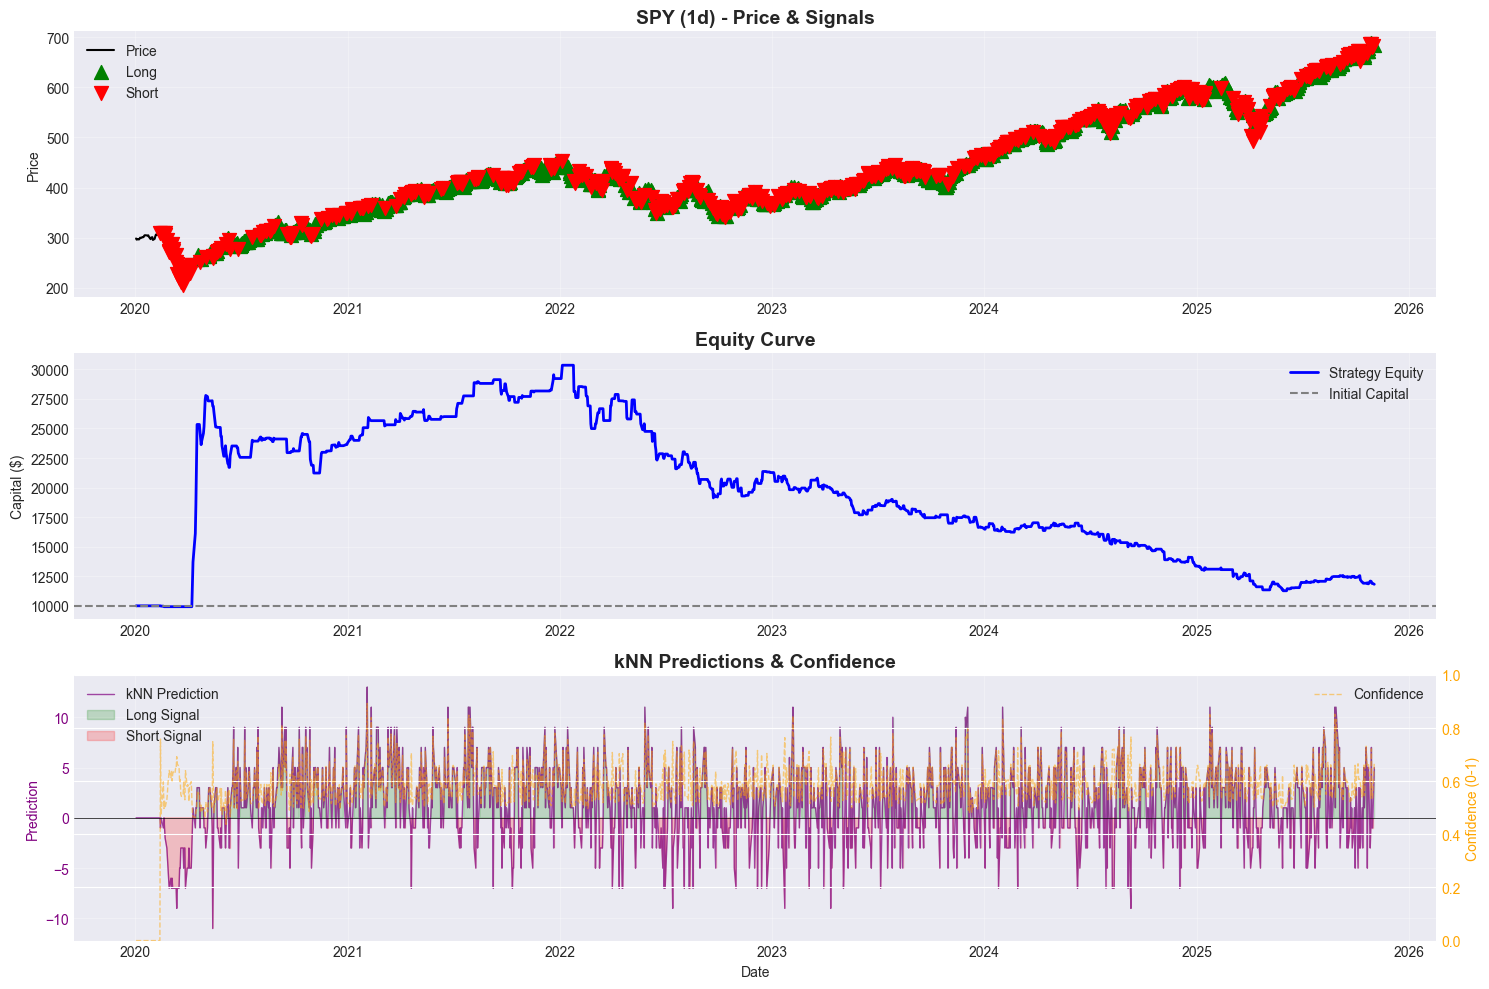

In [7]:
# Example 1: Single asset evaluation
results = evaluate_knn_strategy('SPY', start_date='2020-01-01', interval='1d')
print_results(results)
plot_results(results)



Evaluating SPY (1d) | Last 300 bars
Downloaded 309 bars, using last 300 bars
Downloaded 300 bars
Confidence threshold: 0.50 (only trading on confident predictions)

BACKTEST RESULTS
Symbol: SPY | Timeframe: 1d
Return: -55.31% | Buy&Hold: 23.42% | Excess: -78.73%
Trades: 103 | Win Rate: 49.51% | Profit Factor: 0.56
Sharpe: -1.85 | Avg Win: 1.57% | Avg Loss: -2.75%
Avg Confidence (all): 0.509 | Avg Confidence (trades): 0.579
Confidence Filter: 39 predictions filtered out (threshold: 0.50)
Predictions Used: 231/270 (85.6%)


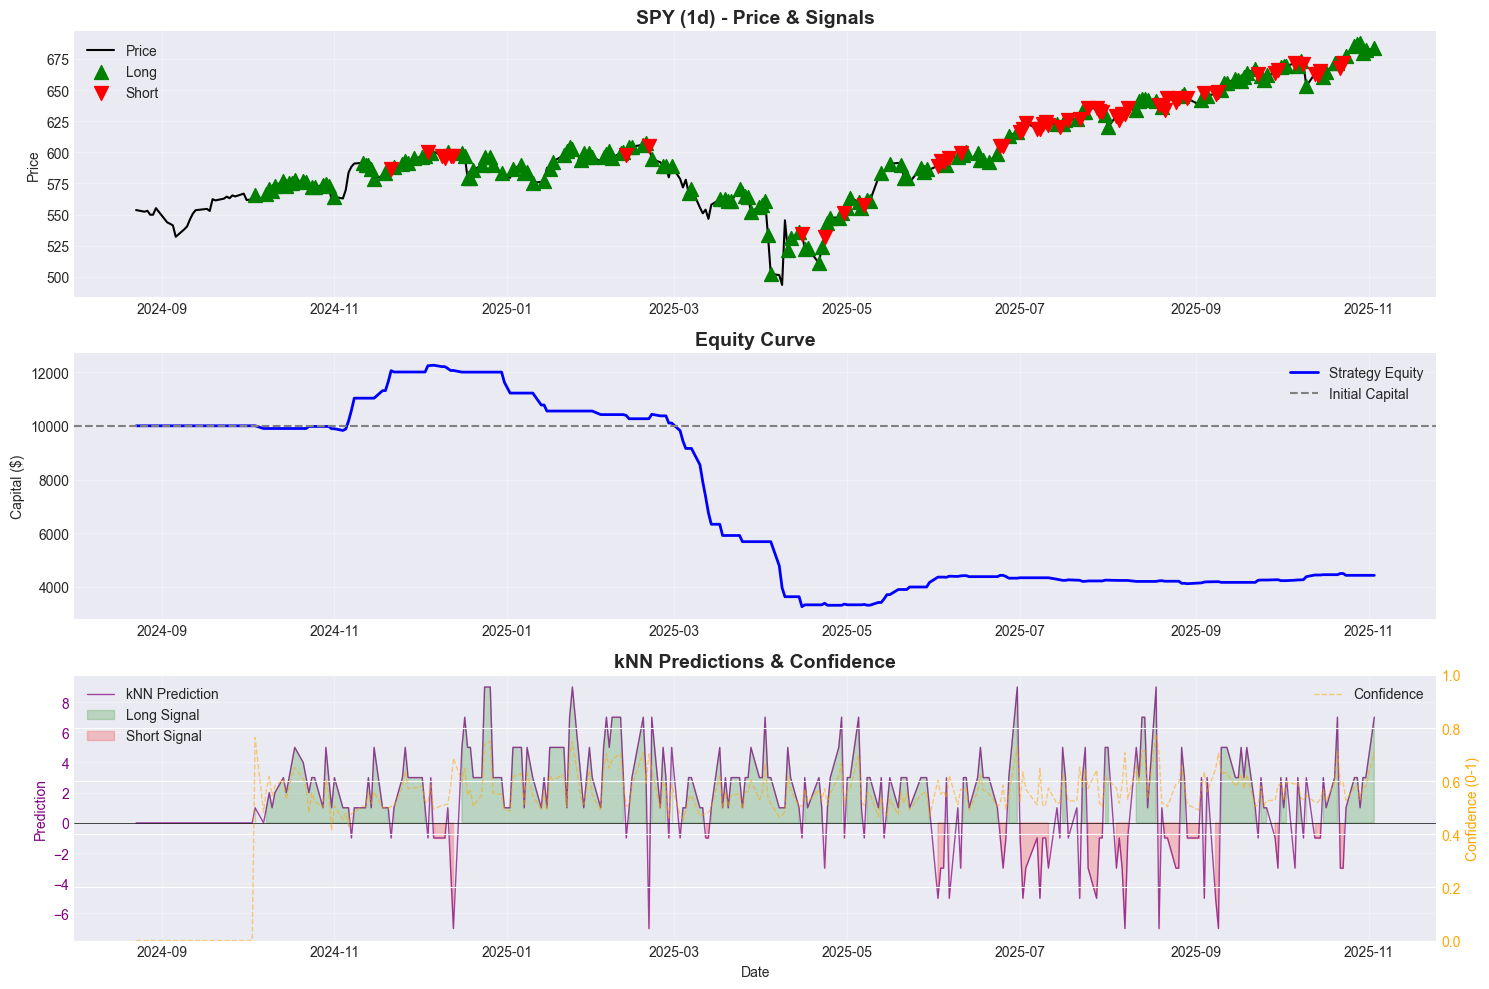

In [8]:
# Example 1: Single asset evaluation
results = evaluate_knn_strategy('SPY', num_rows=300, interval='1d')
print_results(results)
plot_results(results)


In [9]:
# Example 2: Bitcoin intraday
btc_results = evaluate_knn_strategy('BTC-USD', start_date='2024-11-01', interval='1h')
print_results(btc_results, 'BITCOIN 1H BACKTEST')



Evaluating BTC-USD (1h) | 2024-11-01 to all available
Downloaded 8827 bars
Confidence threshold: 0.50 (only trading on confident predictions)

BITCOIN 1H BACKTEST
Symbol: BTC-USD | Timeframe: 1h
Return: -98.39% | Buy&Hold: 49.05% | Excess: -147.45%
Trades: 3886 | Win Rate: 51.60% | Profit Factor: 0.99
Sharpe: -1.29 | Avg Win: 0.46% | Avg Loss: -0.49%
Avg Confidence (all): 0.614 | Avg Confidence (trades): 0.617
Confidence Filter: 59 predictions filtered out (threshold: 0.50)
Predictions Used: 8738/8797 (99.3%)



Evaluating SPY (1h) | Last 1000 bars
Downloaded 308 bars (requested 1000, but only 308 available)
Downloaded 308 bars
Confidence threshold: 0.60 (only trading on confident predictions)

BACKTEST RESULTS
Symbol: SPY | Timeframe: 1h
Return: -0.59% | Buy&Hold: 6.38% | Excess: -6.97%
Trades: 103 | Win Rate: 55.34% | Profit Factor: 1.98
Sharpe: -0.10 | Avg Win: 0.35% | Avg Loss: -0.22%
Avg Confidence (all): 0.664 | Avg Confidence (trades): 0.735
Confidence Filter: 4 predictions filtered out (threshold: 0.60)
Predictions Used: 275/279 (98.6%)


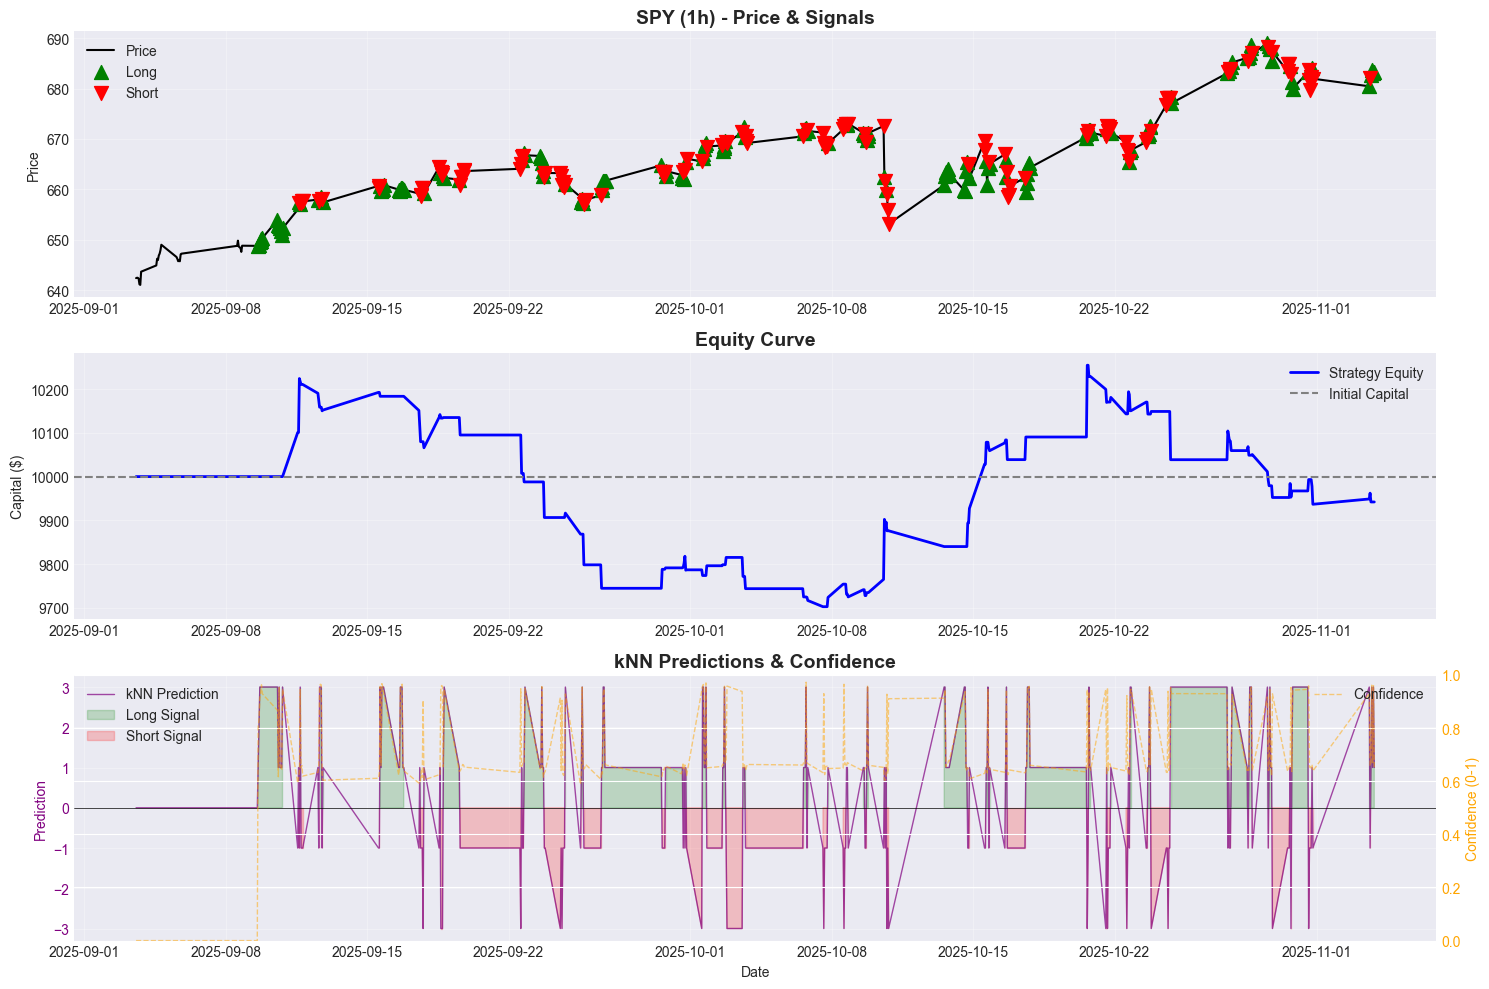

In [19]:
results_with_filter = evaluate_knn_strategy(
    symbol='SPY',
    num_rows=1000,
    interval='1h',
    k=3,
    confidence_threshold=0.6  # Only trade when confidence >= 0.6
)
print_results(results_with_filter)
plot_results(results_with_filter)

In [45]:
# Example 3: Compare multiple assets (grid search k/confidence)
symbols = [
    'SPY',
    'BTC-USD',
    'GC=F',
    'EURUSD=X'
]

intervals = ['5m', '15m', '1h']
num_rows = 1000  # Set your desired lookback for each asset

k_values = [1, 3, 7, 15]
confidence_thresholds = [0.6, 0.7, 0.8]

grid_results = []
for k in k_values:
    for confidence_threshold in confidence_thresholds:
        assets = []
        for symbol in symbols:
            for interval in intervals:
                assets.append({
                    'symbol': symbol,
                    'interval': interval,
                    'num_rows': num_rows,
                    'k': k,
                    'confidence_threshold': confidence_threshold
                })
        comparison = compare_assets(assets)
        comparison['k'] = k
        comparison['confidence'] = confidence_threshold
        grid_results.append(comparison)

import pandas as pd
all_comparisons_df = pd.concat(grid_results, ignore_index=True)

print("\n" + "="*100)
print("MULTI-ASSET KNN COMPARISON (Grid Search)")
print("="*100)
print(all_comparisons_df.to_string(index=False))
print("="*100)



Evaluating SPY (5m) | Last 1000 bars
Downloaded 234 bars (requested 1000, but only 234 available)
Downloaded 234 bars
Confidence threshold: 0.60 (only trading on confident predictions)

Evaluating SPY (15m) | Last 1000 bars
Downloaded 286 bars (requested 1000, but only 286 available)
Downloaded 286 bars
Confidence threshold: 0.60 (only trading on confident predictions)

Evaluating SPY (1h) | Last 1000 bars
Downloaded 308 bars (requested 1000, but only 308 available)
Downloaded 308 bars
Confidence threshold: 0.60 (only trading on confident predictions)

Evaluating BTC-USD (5m) | Last 1000 bars
Downloaded 1433 bars, using last 1000 bars
Downloaded 1000 bars
Confidence threshold: 0.60 (only trading on confident predictions)

Evaluating BTC-USD (15m) | Last 1000 bars
Downloaded 1393 bars, using last 1000 bars
Downloaded 1000 bars
Confidence threshold: 0.60 (only trading on confident predictions)

Evaluating BTC-USD (1h) | Last 1000 bars
Downloaded 1477 bars, using last 1000 bars
Downloade

In [48]:
all_comparisons_df

,Symbol,Timeframe,k,Confidence,Return %,Buy&Hold %,Excess %,Trades,Win Rate %,Sharpe,confidence
0,SPY,5m,1,0.6,-1.139049e+01,0.021950,-1.141244e+01,101,33.663366,-9.995080,0.6
1,SPY,15m,1,0.6,-8.886006e+00,2.192342,-1.107835e+01,114,45.614035,-4.074821,0.6
2,SPY,1h,1,0.6,-9.506078e+00,6.380953,-1.588703e+01,117,46.153846,-2.402929,0.6
3,BTC-USD,5m,1,0.6,-3.458994e+01,-3.399492,-3.119045e+01,428,45.794393,-5.490546,0.6
4,BTC-USD,15m,1,0.6,-4.118176e+01,-3.514327,-3.766744e+01,465,50.107527,-4.093985,0.6
...,...,...,...,...,...,...,...,...,...,...,...
139,GC=F,15m,15,0.8,-7.929229e+01,-5.621350,-7.367094e+01,534,33.333333,-4.405083,0.8
140,GC=F,1h,15,0.8,1.992087e+08,11.077487,1.992087e+08,774,61.757106,6.595401,0.8
141,EURUSD=X,5m,15,0.8,0.000000e+00,-0.679809,6.798085e-01,0,0.000000,0.000000,0.8
142,EURUSD=X,15m,15,0.8,0.000000e+00,-1.209819,1.209819e+00,0,0.000000,0.000000,0.8


## Notes

### Strategy Details
- **Algorithm**: k-Nearest Neighbours for pattern recognition
- **Features**: All indicators normalized to [0,1]
- **Distance**: Euclidean distance in multi-dimensional space
- **Signals**: Aggregate k nearest neighbor directions

### Warnings
- **Look-Ahead Bias**: Uses future direction for training (repainting)
- **Intraday Data**: Limited to ~60 days from Yahoo Finance
- **Overfitting**: Test on out-of-sample data

### Improvements
- Remove look-ahead bias
- Walk-forward optimization
- Stop-loss/take-profit
- Different distance metrics
- Dynamic k optimization
